# Trabalho 4

Aluno: Daniel da Silva Costa

E-mail: danieldasilvacosta@gmail.com

### Imports

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn import metrics
import pandas as pd

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

### Using PyTorch

Based on https://www.youtube.com/watch?v=oPhxf2fXHkQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=13

#### Device configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Hyper-parameters 

In [3]:
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 5
batch_size = 256
learning_rate = 0.001

#### MNIST dataset 

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Data loader

Creating the batches of the training set and test set.

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [6]:
train_loader

In [7]:
# list(enumerate(train_loader))[0]

#### Depicting examples

From test set

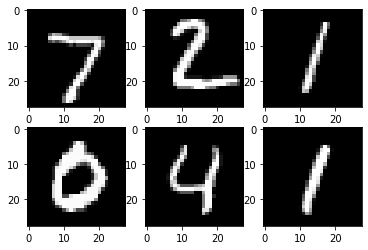

In [8]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

#### Neural Network

In [9]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

In [10]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

#### Loss and optimizer

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

#### Training

In [59]:
%%time

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [100/235], Loss: 0.0284
Epoch [1/5], Step [200/235], Loss: 0.0417
Epoch [2/5], Step [100/235], Loss: 0.0267
Epoch [2/5], Step [200/235], Loss: 0.0383
Epoch [3/5], Step [100/235], Loss: 0.0243
Epoch [3/5], Step [200/235], Loss: 0.0203
Epoch [4/5], Step [100/235], Loss: 0.0251
Epoch [4/5], Step [200/235], Loss: 0.0211
Epoch [5/5], Step [100/235], Loss: 0.0287
Epoch [5/5], Step [200/235], Loss: 0.0075
CPU times: user 25.9 s, sys: 173 ms, total: 26.1 s
Wall time: 26 s


#### Testing

In [78]:
y_predicted = []
y_actual = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        # n_samples += labels.size(0)
        # n_correct += (predicted == labels).sum().item()

        y_predicted += predicted.tolist()
        y_actual += labels.tolist()

In [79]:
len(y_predicted)

10000

In [80]:
len(y_actual)

10000

##### Metrics

Based on https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/

In [90]:
accuracy = metrics.accuracy_score(y_actual, y_predicted)
print( f'Accuracy: {accuracy:.3}' )

Accuracy: 0.981


In [81]:
precision = metrics.precision_score(y_actual, y_predicted, average = 'weighted')
print( f'Precision: {precision:.3}' )

Precision: 0.981


In [82]:
recall = metrics.recall_score(y_actual, y_predicted, average = 'weighted')
print( f'Recall: {recall:.3}' )

Recall: 0.981


In [83]:
f1_score = metrics.f1_score(y_actual, y_predicted, average = 'weighted')
print( f'F1 Score: {f1_score:.3}' )

F1 Score: 0.981


In [91]:
jaccard = metrics.jaccard_score(y_actual, y_predicted, average = 'weighted')
print( f'Jaccard: {jaccard:.3}' )

Jaccard: 0.962


In [93]:
balanced_accuracy = metrics.balanced_accuracy_score(y_actual, y_predicted)
print( f'Balanced Accuracy: {balanced_accuracy:.3}' )

Balanced Accuracy: 0.98


##### Confusion Matrix

In [85]:
confusion_matrix = metrics.confusion_matrix(y_actual, y_predicted)

In [86]:
# based on https://www.statology.org/confusion-matrix-python/

y_actual = pd.Series(y_actual, name='Actual')
y_predicted = pd.Series(y_predicted, name='Predicted')

#create confusion matrix
print(pd.crosstab(y_actual, y_predicted))

Predicted    0     1     2    3    4    5    6     7    8    9
Actual                                                        
0          973     0     1    1    1    1    1     1    1    0
1            0  1123     4    0    0    1    2     1    4    0
2            6     2  1006    1    2    0    2     6    7    0
3            2     0     1  992    0    5    0     4    4    2
4            2     0     2    0  961    0    4     3    0   10
5            2     0     0    7    2  875    3     0    2    1
6            6     2     1    1    4    4  939     0    1    0
7            1     4     6    3    0    0    0  1007    2    5
8            9     1     2    3    4    6    2     2  940    5
9            2     2     0    3    6    2    0     3    1  990


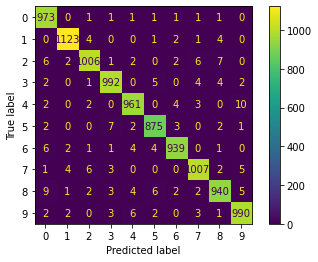

In [87]:
# based on https://www.w3schools.com/python/python_ml_confusion_matrix.asp

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix, 
    display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cm_display.plot()
plt.show()

### Exporting to HTML file

Changing Google Drive folder.

In [94]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

In [95]:
# !cd "./drive/MyDrive/Doutorado/Disciplinas/[2022.2] [PUC-Rio] Visão Computacional - Professor: Marcelo Gattass/Trabalhos/Trabalho 4"

In [96]:
# !pwd

In [ ]:
# %%time


# !jupyter nbconvert --to html ./T4_DanielCosta.ipynb